<h1 align="center">2019 Midterm</h1>
<h4 align="center">Ziyuan Shen, NetID: zs83</h4>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

#### Pr. 1.1
Consider the data set in Lab 1. This is the Advertisement.csv data set.

1.Compute the leave-on-out cross validation error for a Gaussian process regression model as well as a Bayesian linear regression model.

Data preprocessing:

In [2]:
data_df = pd.read_csv('Advertisement.csv')
data_df.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [3]:
X = data_df[['TV','radio','newspaper']].values
y = data_df.sales.values

Gaussian Process Regression:

A simple radius basis function kernel is used, which is defined as,
\begin{equation}
K(x,x')=exp\left (-\frac{||x-x'||^2}{2}\right )
\end{equation}

noise is set to $0.1$,

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
kernel = RBF(length_scale=1)
gpr = GaussianProcessRegressor(kernel=kernel,alpha=0.1,random_state=0).fit(X,y)
gpr.score(X,y)

0.9898100583747501

Cross-Validation error is defined as:
\begin{equation}
I[cv]=\frac{1}{n}\sum_{i=1}^{n}{(y_i-{\hat{f}}_{D^{\backslash i}}(x_i))}^2
\end{equation}

According to this formula, the cross validation error for Gaussian process regression is computed as follows:

In [5]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
error_list1 = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gpr = GaussianProcessRegressor(kernel=kernel,alpha=0.1,random_state=0)\
    .fit(X_train, y_train)
    y_hat = gpr.predict(X_test)
    error = (y_hat - y_test) ** 2
    error_list1.append(error)
I_cv = sum(error_list1) / len(error_list1)
print('Cross validation error for Gaussian process regression : {}'.format(I_cv[0]))

Cross validation error for Gaussian process regression : 0.43839471117738127


Bayesian Linear Regression:
\begin{equation}
\begin{aligned}
&\beta|Y,\mathbf{X},{\sigma}^2\sim N_p(\mu_1,\Sigma_1)\\
&\Sigma_1=({\tau_0}^{-2}\mathbf{I}_p+\sigma^{-2}\mathbf{X}^T\mathbf{X})^{-1},\quad \mu_1=\sigma^{-2}\Sigma_1\mathbf{X}^TY\\
&y_{\ast}|D,x_{\ast},\sigma^2,\tau_0^2\sim N(\mu_{\ast},\sigma_{\ast}^2)\\
&\mu_{\ast}=\frac{1}{\sigma^2}\Sigma_1\mathbf{X}^TYx_{\ast}=\mu_1x_{\ast},\quad \sigma_{\ast}^2=\sigma^2+x_{\ast}^T\Sigma_1x_{\ast}
\end{aligned}
\end{equation}

The following function implements Bayesian linear regressioin. Having $X,Y$ and $x_{\ast}$ as inputs, the mean value and standard variance value of $y_{\ast}$ is returned. The default value for $\sigma$ and $\tau_0$ are both set to $0.01$:

In [6]:
import math

def BayesianLinearRegression(X, y, X_star, sigma=0.01, tau=0.01):
    p = X.shape[1]
    I_p = np.identity(p)
    Sigma_1 = np.linalg.inv(I_p / (tau ** 2) + (np.dot(X.T, X) / (sigma ** 2)))
    mu_1 = np.dot(np.dot(Sigma_1, X.T), y) / (sigma ** 2)
    mu_star = np.dot(X_star, mu_1[:,np.newaxis])
    var_star = sigma ** 2 + np.dot(np.dot(X_star, Sigma_1), X_star.T)
    std_star = math.sqrt(var_star)
    return mu_star, std_star

Cross Validation error for Bayesian linear regression is computed as follows:

In [7]:
error_list3 = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_hat, std_star = BayesianLinearRegression(X_train, y_train, X_test, sigma=1, tau=1)
    error = (y_hat - y_test) ** 2
    error_list3.append(error)
I_cv = sum(error_list3) / len(error_list3)
print('Cross validation error for linear regression : {}'.format(I_cv[0][0]))

Cross validation error for linear regression : 4.167440938936757


2.Plot the predictive posterior distribution when observations 1, 50, 100, 150 are respectively left out of the training set and you are asked to predict their response.

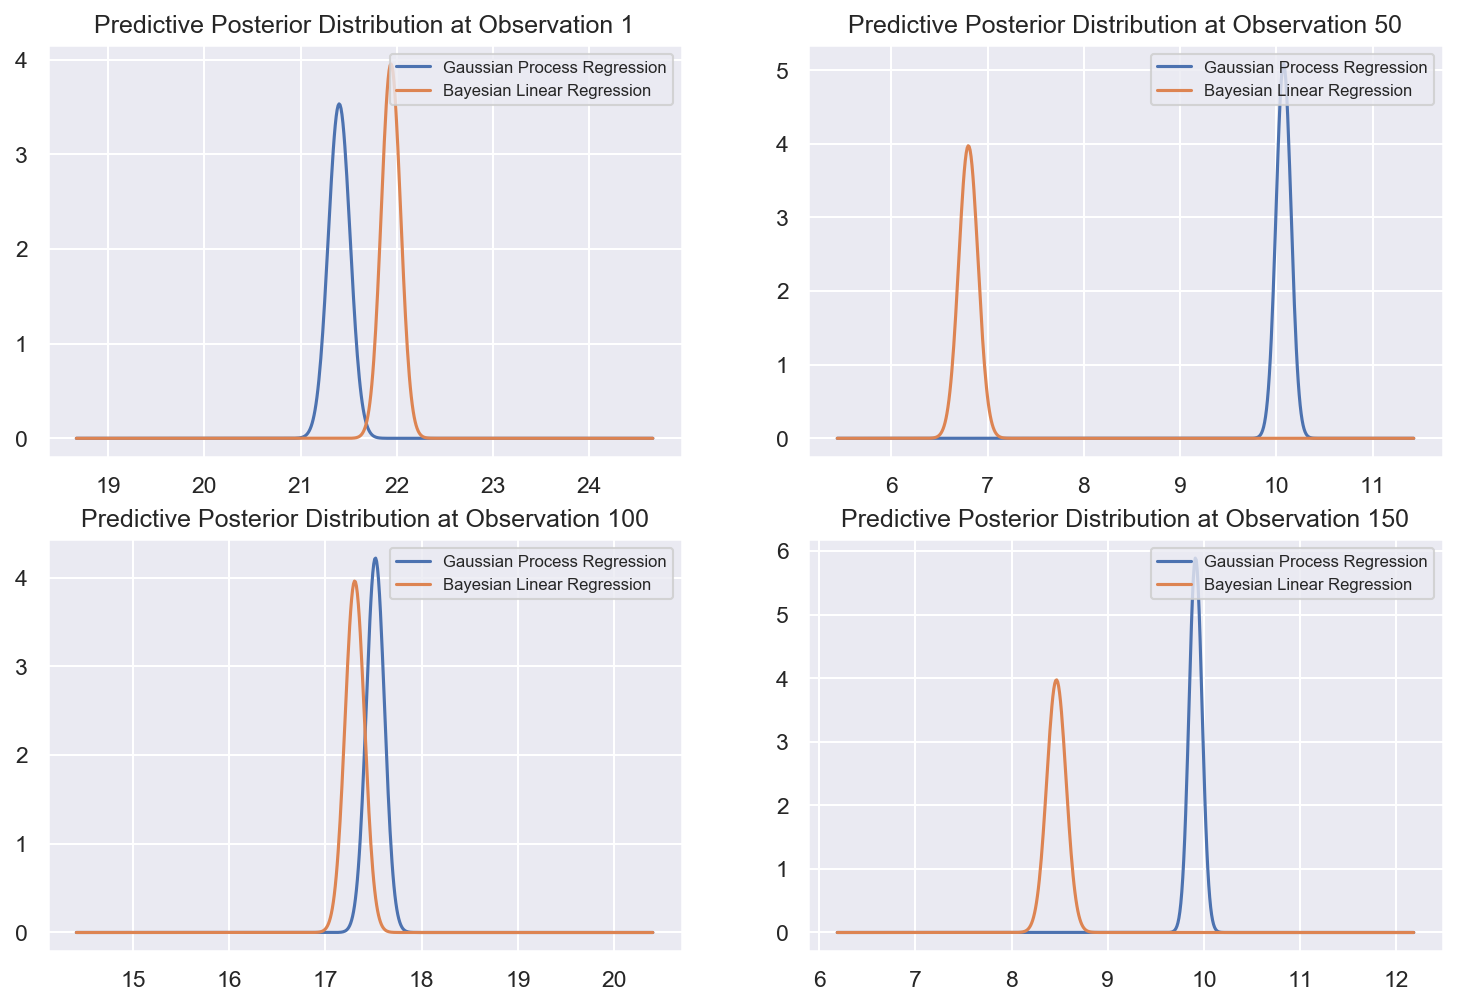

In [8]:
from scipy.stats import norm
fig = plt.figure(figsize=(12,8),dpi=150)
for i, idx in enumerate([0,49,99,149]):
    X_train = X[np.arange(X.shape[0])!=idx]
    y_train = y[np.arange(X.shape[0])!=idx]
    X_test = X[idx:idx+1]
    y_test = y[idx:idx+1]
    gpr = GaussianProcessRegressor(kernel=kernel,alpha=0.1,random_state=0).fit(X_train, y_train)
    mu, std = gpr.predict(X_test, return_std=True)
    mu_star, std_star = BayesianLinearRegression(X_train, y_train, X_test, sigma=0.1, tau=0.01)
    x_axis = np.arange(-3+(mu+mu_star)/2, 3+(mu+mu_star)/2, 0.01)
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(x_axis, norm.pdf(x_axis,mu,std), label='Gaussian Process Regression')
    ax.plot(x_axis, norm.pdf(x_axis,mu_star[0][0],std_star), label='Bayesian Linear Regression')
    ax.legend(loc='upper right', prop={'size': 8})
    ax.set_title("Predictive Posterior Distribution at Observation {}".format(idx+1))

3.Use a bootstrap procedure to output confidence intervals when observations1, 50, 100, 150 are respectively left out of the training set and you are asked to use ordinary least squares as your regression method.

Each time, the rest of the observations are resampled $1000$ times to get $1000$ models and the response is predicted $1000$ times. The $95\%$ confidence intervals are computed as follows:

In [9]:
from sklearn.linear_model import LinearRegression

for idx in [0,49,99,149]:
    X_train = X[np.arange(X.shape[0])!=idx]
    y_train = y[np.arange(X.shape[0])!=idx]
    X_test = X[idx:idx+1]
    y_test = y[idx:idx+1]
    y_hat = np.zeros(1000)
    for i in range(1000):
        sample_index = np.random.choice(range(0, len(y_train)-1), len(y_train)-1)
        X_samples = X_train[sample_index]
        y_samples = y_train[sample_index]
        lr = LinearRegression().fit(X_samples,y_samples)
        y_hat[i] = lr.predict(X_test)
    conf_int = np.percentile(y_hat,[2.5,97.5])
    print('Confidence interval for obversation %s is :[%.3f,%.3f]' % (idx+1,conf_int[0],conf_int[1]))

Confidence interval for obversation 1 is :[19.924,21.004]
Confidence interval for obversation 50 is :[7.739,8.553]
Confidence interval for obversation 100 is :[16.451,17.454]
Confidence interval for obversation 150 is :[9.287,10.367]


#### Pr. 1.2
Write out the EM update steps for a mixture of multinomials model. Specifically, consider the following likelihood
\begin{equation}
f(x_1,\dots,x_n;\pi,\{\theta_1,\dots,\theta_7\})=\prod_{i=1}^{n} \left [\sum_{k=1}^{7}\pi_kf(x_i;\theta_k) \right ]
\end{equation}
where x takes values $1,\dots,4$ (there are four categories) and
\begin{equation}
f(x=c;\theta)=\theta_c,\quad \theta_c \ge 0 \quad and \sum_{c}\theta_c=1
\end{equation}

Answer:

Complete data log likelihood:
\begin{equation}
\begin{aligned}
\mathscr{l}_C(\theta;Z,X) & =\sum_{i=1}^{n}{\rm log}p(x_i,z_i|\theta)\\
                          & =\sum_{i=1}^{n}{\rm log}p(x_i|z_i,\theta)p(z_i|\pi)\\
                          & =\sum_{i=1}^{n}{\rm log}p(z_i|\pi)+{\rm log}p(x_i|z_i,\theta)\\
                          & =\sum_{i=1}^{n}\sum_{k=1}^{7}z_i^k\left({\rm log}p(z_i=k)+{\rm log}f(x_i;\theta_k)\right)\\
                          & =\sum_{i=1}^{n}\sum_{k=1}^{7}z_i^k{\rm log}\pi_k+z_i^k{\rm log}f(x_i;\theta_k)\\
\end{aligned}
\end{equation}

Expectation of the latent variables:
\begin{equation}
\begin{aligned}
Q(\theta^t) & =E_{\theta^t}\left[\mathscr{l}_C(\theta;Z,X)\right]\\
            & =E_{\theta^t}\left[\sum_{i=1}^{n}\sum_{k=1}^{7}z_i^k{\rm log}\pi_k+z_i^k{\rm log}f(x_i;\theta_k)\right]\\
            & =\sum_{i=1}^{n}\sum_{k=1}^{7}E_{\theta^t}[z_i^k]{\rm log}\pi_k+E_{\theta^t}[z_i^k]{\rm log}f(x_i;\theta_k)
\end{aligned}
\end{equation}

E-step: for each $i,k$
\begin{equation}
\begin{aligned}
r_{ik}^{t+1} & =E_{\theta^{t+1}}[z_i^k]\\
             & =p(z_i=k|\theta^t,x_i)\\
             & =\frac{p(z_i=k,x_i|\theta^t)}{p(x_i|\theta^t)}\\
             & =\frac{p(z_i=k|\pi)p(x_i|z_i=k,\theta^t)}{p(x_i|\theta^t)}\\
             & =\frac{\pi_k^tf(x_i;\theta_k^t)}{\sum_{j=1}^7\pi_j^tf(x_i;\theta_j^t)}
\end{aligned}
\end{equation}



M-step: updata $\theta^t$ to $\theta^{t+1}$,
\begin{equation}
\begin{aligned}
\theta^{t+1} & =\underset{\theta}{\operatorname{argmax}}Q(\theta^t)\\
             & =\underset{\theta}{\operatorname{argmax}}\sum_{i=1}^{n}\sum_{k=1}^{7}E_{\theta^t}[z_i^k]{\rm log}\pi_k+E_{\theta^t}[z_i^k]{\rm log}f(x_i;\theta_k)\\
             & =\underset{\theta}{\operatorname{argmax}}\sum_{i=1}^{n}\sum_{k=1}^{7}r_{ik}^t{\rm log}\pi_k+r_{ik}^t{\rm log}f(x_i;\theta_k)\\
\end{aligned}
\end{equation}

For notation clarity, let $\theta_k=[\theta_{k,1},\theta_{k,2},\theta_{k,3},\theta_{k,4}]$, where $f(x=j;\theta_k)=\theta_{k,j}$ and $\sum_{j=1}^{4}\theta_{k,j}=1$. More specifically,
\begin{equation}
\begin{aligned}
\pi_k^{t+1} & =\frac{\sum_{i=1}^nr_{ik}^t}{n}\\
\theta_{k,j}^{t+1} & =\frac{\sum_{i=1}^nr_{ik}^t(x_i==j)}{\sum_{i=1}^nr_{ik}^t},\quad j=1,2,3,4
\end{aligned}
\end{equation}

#### Pr. 1.3
Given the classification data set in Lab 2 run regularized logistic regression versus SVM and compare classification accuracy on a test-train split.

Data preprocessing:

In [10]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data'
col_names = ['id','ri','na','mg','al','si','k','ca','ba','fe','glass_type']
glass_df = pd.read_csv(url, names=col_names, index_col='id')
glass_df.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type
id,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


The glass type is classified into two categories of household:

In [11]:
glass_df['household'] = glass_df.glass_type.map({1:0, 2:0, 3:0, 5:1, 6:1, 7:1})
glass_df.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type,household
id,,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1,0
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1,0
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1,0
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1,0
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1,0


The data is randomly separated into 50% training set and 50% testing set.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X = glass_df[['ri','na','mg','al','si','k','ca','ba','fe']].values
y = glass_df.household.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

Regularized Logistic Regression:

With 'L2' regularization, logistic regression solves,
\begin{equation}
\underset{w,c}{\operatorname{argmin}}\frac{1}{2}w^Tw+C\sum_{i=1}^n{\rm log}(exp(-y_i(X_i^Tw+c))+1)
\end{equation}

Prediction accuracy is calculated as follows, with parameter $C$ set to $10$,

In [13]:
clf_lr = LogisticRegression(penalty='l2',C=10,solver='newton-cg').fit(X_train,y_train)
y_hat = clf_lr.predict(X_test)
accuracy = (y_hat == y_test).sum() / len(y_test)
print('Logistic regression classification accuracy: {}'.format(accuracy))

Logistic regression classification accuracy: 0.9252336448598131


Support Vector Machine:
\begin{equation}
\underset{w,b}{\operatorname{argmin}}\frac{1}{2}w^Tw+C\sum_{i=1}^n\xi_i\\
{\rm subject \quad to}\quad y_i(w^Tx_i+b)\ge 1-\xi_i,\\
\xi_i \ge 0,\quad i=1,2,\dots,n
\end{equation}

Prediction accuracy is calculated as follows, with parameter $C$ set to $10$,

In [14]:
from sklearn.svm import SVC
clf_svm = SVC(C=10,gamma='auto').fit(X_train,y_train)
y_hat = clf_svm.predict(X_test)
accuracy = (y_hat == y_test).sum() / len(y_test)
print('SVM classification accuracy: {}'.format(accuracy))

SVM classification accuracy: 0.9439252336448598


Based on the experiment, SVM performs a little better than logistic regression.

#### Pr. 1.4
Show that the EM algorithm does not decrease with respect to the likelihood value at
each step.

Answer:

Say complete data is $D=(X,Z)$, where $X$ is observed data and $Z$ is unobserved data. The data log likelihood is:
\begin{equation}
\begin{aligned}
\mathscr{l}(\theta,X) & ={\rm log}p(X|\theta)\\
                      & ={\rm log}\frac{p(X,Z|\theta)}{p(Z|X,\theta)}\\
                      & ={\rm log}p(X,Z|\theta)-{\rm log}p(Z|X,\theta)\\
                      & =E_{\theta^t}[\mathscr{l}(\theta,X)|X]\\
                      & =E_{\theta^t}[{\rm log}p(X,Z|\theta)|X]-E_{\theta^t}[{\rm log}p(Z|X,\theta)|X]\\
                      & =Q(\theta|\theta^t)-H(\theta|\theta^t),
\end{aligned}
\end{equation}

where $H(\theta|\theta^t)=E_{\theta^t}[{\rm log}p(Z|X,\theta)|X]$.

\begin{equation}
\begin{aligned}
\mathscr{l}(\theta^{t+1},X)-\mathscr{l}(\theta^t,X) & =\left(Q(\theta^{t+1}|\theta^t)-H(\theta^{t+1}|\theta^t)\right)-\left(Q(\theta^t|\theta^t)-H(\theta^t|\theta^t)\right)\\
& =\left(Q(\theta^{t+1}|\theta^t)-Q(\theta^t|\theta^t)\right)-\left(H(\theta^{t+1}|\theta^t)-H(\theta^t|\theta^t)\right)
\end{aligned}
\end{equation}

In Expectation Maximization, $\theta$ is chosen to maximize $Q(\theta|\theta^t)$ at each step. Therefore, $Q(\theta^{t+1}|\theta^t)-Q(\theta^t|\theta^t)\ge 0$.

By Jensen's inequality,
\begin{equation}
\begin{aligned}
H(\theta^{t+1}|\theta^t)-H(\theta^t|\theta^t) & =E_{\theta^t}\left[{\rm log}\frac{p(Z|X,\theta^{t+1})}{p(Z|X,\theta^t)}|X\right]\\
& \le {\rm log}E_{\theta^t}\left[\frac{p(Z|X,\theta^{t+1})}{p(Z|X,\theta^t)}|X\right]\\
& ={\rm log}\int \frac{p(z|X,\theta^{t+1})}{p(z|X,\theta^t)} p(z|X,\theta^t) dz\\
& ={\rm log}1=0
\end{aligned}
\end{equation}

Thus,
\begin{equation}
\mathscr{l}(\theta^{t+1},X)-\mathscr{l}(\theta^t,X)\ge0.
\end{equation}

Reference:

<sub>[1] https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm<sub>

#### Pr. 1.5
Sketch how the Least Angle Regression problem implements a form of sparse regression.

Least Angle regression is a model selection algorithm that modifies Lasso and forward stagewise regression. It generates parsimonious models with fewer features thus can implement sparse regression. The advantage of LARS is reducing computational burden. LARS only requires $m$ steps, where $m$ is the number of covariates.

Basically, LARS starts with an empyt set and has the following steps:

1) Select $x_{j_1}$ that is most correlated with $y-\hat{\mu}$;

2) Proceed in the direction of $x_{j_1}$ until another variable $x_{j_2}$ is equally correlated with residuals

3) Choose equiangular direction between $x_{j_1}$ and $x_{j_2}$

4) Proceed until third variable enters the active set

Reference:

<sub>[1] Efron, B., Hastie, T., Johnstone, I., & Tibshirani, R. (2004). Least angle regression. The Annals of statistics, 32(2), 407-499.\<sub>

#### Pr. 1.7
Run the sklearn.mixture program with 8 components. Output the probability assignment for each observation. Explain the difference between a hard assignment versus a soft
assignment for each observation.

Sythetic data of $8$ clusters are generated using sklearn make_blobs:

In [15]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples = 400, centers = 8, cluster_std = 0.6, random_state = 10)
X = X[:, ::-1]

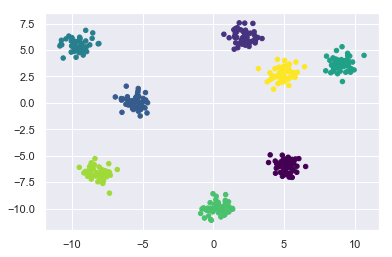

In [16]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 8, random_state = 0).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis');

In [17]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]


Difference between a hard assignment versus a soft
assignment:

Hard assignment assigns the best cluster for each data point, while soft assignment assigns the probability of each cluster for each data point.